# Pong RL DQN implementation

Teaching a machine to play an Atari game PONG using reinforcement learning, code adapted from TF-Agents tutorials and (Geron 2019).

Specific libraries:

    - tensorflow, keras
    - gym Atari environment (pip install gym[atari])

References:

    - Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. A. (2013). Playing atari with deep reinforcement learning CoRR, abs/1312.5602. Retrieved from http://arxiv.org/abs/1312.5602
    - Geron, A. (2019). Hands-on machine learning with scikit-learn, keras, and tensorflow: Concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly UK Ltd.
    - Sutton, R. S., & Barto, A. G. (2018). Reinforcement Learning: An Introduction (2nd ed.). Cambridge: MIT Press.
    - Lillicrap, T., P., Hunt, J., Pritzel, A.,Heess, N., Erez, T., Tassa, Y., Silver, D., Wierstra, D. (2016 ) Continuous control with deep reinforcement learning. Retrieved from http://arxiv.org/abs/1509.02971 

    


In [10]:
## import basic libraries:
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import logging
#import pyvirtualdisplay
from functools import partial
from gym.wrappers import TimeLimit
import time
import reverb

# import required tf-agents components
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4
from tf_agents.utils import common
from tf_agents.metrics import tf_metrics
from tf_agents.metrics import py_metrics
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.eval.metric_utils import log_metrics
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.trajectories.trajectory import to_transition
from tf_agents.utils.common import function
#from tf_agents.specs import array_spec
#from tf_agents.specs import tensor_spec
from tf_agents.agents.dqn.dqn_agent import DqnAgent

from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils


ImportError: libpython3.7m.so.1.0: cannot open shared object file: No such file or directory

In [2]:
# stable and repeatable runs:
np.random.seed(42)
tf.random.set_seed(42)

# load the atari environment
max_episode_frames = 108000 
env_name = "PongNoFrameskip-v4"

env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames/4,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

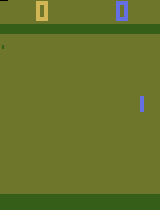

In [3]:
env.reset()
PIL.Image.fromarray(env.render())

In [4]:
# create 4 time steps, each taking a action step left
env.reset()
time_step = env.step(1) # FIRE
for _ in range(4):
    time_step = env.step(3) # LEFT

In [5]:
# from (Geron, 2017) - plot 4 steps in one observation utilising RGB color channels
def plot_observation(obs):
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

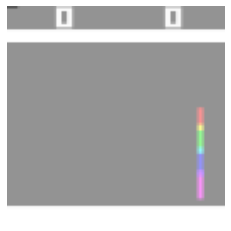

In [6]:
plt.figure(figsize=(4, 4))
plot_observation(time_step.observation)
plt.show()

In [7]:
# to make the environment usable from within TF graph
from tf_agents.environments.tf_py_environment import TFPyEnvironment
tf_env = TFPyEnvironment(env)

## DQN

In [8]:
# Q-Network, DQN
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

## Agent

In [9]:
# Agent

#allowlr =array_spec.BoundedArraySpec(shape=(), dtype=np.int64, name='action', minimum=0, maximum=6)

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
learning_rate = 2.5e-4
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=150000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε

agent = DqnAgent(tf_env.time_step_spec(),
                 #allowlr,
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=common.element_wise_squared_loss,
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))

agent.initialize()

In [10]:
# Show progress class

class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

## Replay Buffer

In [11]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
replay_buffer_max_length = 5000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)

replay_buffer_observer = replay_buffer.add_batch

In [16]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [7]:
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, min_size_to_sample=3, error_buffer=3.0)

NameError: name 'reverb' is not defined

In [ ]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

## Logging

In [12]:
# create training metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [13]:
# do the logging
logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(filename='DQN.log', level=logging.INFO)
log_metrics(train_metrics)

## Collect Driver

In [14]:
#Create the Collect Driver, passes current tie step to the collect policy, which returns the action step

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

In [15]:
# warm up the replay buffer with random policy
initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames as in 2015 DQN paper by DeepMind
final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
20000/20000

## Create the Dataset

## Training Loop

In [17]:
# convert the main functions to TF functions

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [18]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    startt=time.time()
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy()), end="")
        if iteration % 500 == 0:
            logg=[]
            for a in train_metrics:
                logg = np.round(np.append(logg, np.asscalar(a.result().numpy())),2)
            f=open('DQN.txt','ab')
            np.savetxt(f, [logg], delimiter=",", fmt='%.1f')
            f.close()
            startt=time.time()
            print(np.round(logg,1))


In [66]:
train_agent(n_iterations=200000)

0 loss:0.02971[   9.  8192.   -19.7  893.1]
129 loss:0.00087

KeyboardInterrupt: 

## Create visualisation

In [21]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [22]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(1)
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

1000/1000

In [23]:
image_path = os.path.join("pong.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:500]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=60,
                     loop=0)

In [24]:
%%html
<img src="pong.gif" />